# Preprocesamiento del Dataset y Selección de Variables

Este notebook tienen como objetivo la fase de "ingeniería" donde transformamos los **datos crudos** (los que obtuvimos en el EDA) en el combustible limpio y de alto octanaje que usaremos para entrenar nuestros modelos.

Basado en nuestros hallazgos en la fase anterior (outliers, gaps, MNAR, correlaciones), tomarmos decicisones que nos lleven a alcanzar ese objetivo.

# Fase A: Preparación de Datos Base

## 1. Carga de Datos

In [1]:
# Seteo inicial

import sys
import logging
import warnings
from pathlib import Path

# Configuración de logging y advertencias
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
warnings.filterwarnings('ignore')


# Configuración de Paths
BASE_DIR = Path('../').resolve()
DATA_DIR = BASE_DIR / 'data'
SRC_DIR = BASE_DIR / 'src'
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
sys.path.append(str(SRC_DIR))

logging.info(f"Directorio Base: {BASE_DIR}")
logging.info(f"Directorio de Datos: {DATA_DIR}")
logging.info(f"Directorio Procesado: {PROCESSED_DIR}")
logging.info(f"Directorio Src: {SRC_DIR}")

2025-11-16 17:37:08,207 - Directorio Base: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF
2025-11-16 17:37:08,209 - Directorio de Datos: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/data
2025-11-16 17:37:08,209 - Directorio Procesado: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/data/processed
2025-11-16 17:37:08,210 - Directorio Src: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/src


### Cargar el Dataset Base

In [2]:
import pandas as pd

df = pd.read_csv(PROCESSED_DIR / 'dataset_v01.csv', parse_dates=['Fecha'], index_col='Fecha')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1190 entries, 2020-07-01 23:59:00 to 2023-10-26 07:00:00
Columns: 149 entries, Planta (Kw) to Totalizador_Filtracion
dtypes: float64(145), int64(4)
memory usage: 1.4 MB


---

## 2. Limpieza y Acondicionamiento de fechas.

### Limpieza de Rango de Fechas

Como vimos durante el EDA, algunas de nuestras fechas faltan o estan incompletas (no llegan hasta las 23:59). En este apartado vamos a tratar esas filas para dejarlas en condiciones antes del preporcesado.

In [3]:
# Ejemplo de fila incompleta
df.last_valid_index()

Timestamp('2023-10-26 07:00:00')

En este caso, como `2023-10-26` es la última fila lo más sencillo es eliminarla. Esto ya que no provoca una pérdida de continuidad y tenemos datos suficientes como para permitirnoslo.

In [4]:
df = df.loc[df.index < '2023-10-26']

# Nuestra fecha máxima de datos ahora es 2023-10-25
df.last_valid_index()

Timestamp('2023-10-25 23:59:00')

Ahora vamos a buscar las fechas con horas distintas a las `23:59:00` y decidiremos si las eliminamos (considerándolas como día faltantes) o si las conservamos como están.

In [5]:
import numpy as np

# Verificar si hay fechas con horas distintas a 23:59:00

# Extraer la hora de cada índice
df_horas = df.index.to_series().apply(lambda x: x.strftime('%H:%M:%S'))

# Identificar las fechas que no terminan en 23:59:00
fechas_incompletas = df[df_horas != '23:59:00']

print(f"Total de fechas con horas distintas a 23:59:00: {len(fechas_incompletas)}")

print("\nFechas incompletas encontradas:")
# Las ordenamos por hora de forma ascendente para facilitar su revisión y solo comparamos la columna 'Frio (Kw)'
fechas_incompletas = fechas_incompletas.assign(hora=df_horas[df_horas != '23:59:00']).sort_values(by='hora')
display(fechas_incompletas['Frio (Kw)'])

Total de fechas con horas distintas a 23:59:00: 19

Fechas incompletas encontradas:


Fecha
2023-04-19 16:00:00    13439.0
2023-04-13 19:00:00    14315.0
2022-03-02 23:00:00    19294.0
2021-07-13 23:00:00    33704.0
2023-02-23 23:59:01    20688.0
2022-12-08 23:59:01    21663.0
2022-04-29 23:59:01    31316.0
2022-04-05 23:59:01    22573.0
2020-08-12 23:59:01    29964.0
2021-04-11 23:59:01    26888.0
2020-12-30 23:59:01    11433.0
2020-10-22 23:59:01    28374.0
2020-10-08 23:59:01    30220.0
2020-08-25 23:59:01    37809.0
2021-08-25 23:59:01    37122.0
2023-07-07 23:59:01    22348.0
2023-06-30 23:59:59    20274.0
2021-06-30 23:59:59    32571.0
2022-06-30 23:59:59    26459.0
Name: Frio (Kw), dtype: float64

Como vemos, la gran mayoría de estas fechas tienen diferencias de **segundos** con la hora que estamos comparando, por lo que vamos a tomarlas como válidas. También lo haremos con las fechas con hora `23:00:00`, siguen aportando información relevante y suficiente para nuestro análisis.

En cambio, aquellos días que poseen horas `< 23:00:00` vamos a eliminarlas y las tomaremos como valores faltantes que trataremos más adelante.

In [6]:
print("Shape previo a filtrado:", df.shape)

df =  df.loc[~((df.index.to_series().apply(lambda x: x.strftime('%H:%M:%S')) < '23:00:00'))]

print("Shape posterior a filtrado:", df.shape)

Shape previo a filtrado: (1189, 149)
Shape posterior a filtrado: (1187, 149)


In [7]:
# Eliminar la hora del índice, dejando solo la fecha
df.index = df.index.normalize()
df.tail()

,Planta (Kw),Elaboracion (Kw),Bodega (Kw),Cocina (Kw),Envasado (Kw),Linea 2 (Kw),Linea 3 (Kw),Linea 4 (Kw),Servicios (Kw),Sala Maq (Kw),...,Tot L3. L4 y Planta de CO2,Tot A40/240/50/60/Centec/Filtro,Tot A130/330/430,"Tot L3, L4 y Planta de CO2",Totalizador_L2_Barriles,Totalizador_L3,Totaliador_Latas,Totalizador_Bodega,Totalizador_Tq_Pulmon,Totalizador_Filtracion
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-10-21,21627.800000,2383.0,3119.0,242.0,452.0,461.300000,546.0,0.0,16977.0,9793.0,...,NaN,2194.000,6922.250,40.12500,0.0,0.0,0.0,0.0000,1649.0,0.0
2023-10-22,30287.570000,3200.0,2788.0,1387.0,2758.0,4351.070000,584.0,0.0,20821.0,11873.0,...,NaN,2070.875,6019.625,72.56250,1271.0,0.0,0.0,7.9375,2863.0,1.0
2023-10-23,28667.480000,2329.0,2882.0,313.0,3339.0,5503.480000,550.0,0.0,18771.0,10395.0,...,NaN,1828.250,6030.000,74.53125,1323.0,0.0,0.0,0.0000,3244.0,1.0
2023-10-24,31263.160156,3077.0,3405.0,235.0,5513.0,6940.660156,1287.0,0.0,18461.0,10614.0,...,NaN,728.500,6006.000,79.78125,1485.0,0.0,0.0,952.0625,4538.0,737.0
2023-10-25,30501.320312,3194.0,3671.0,251.0,4306.0,6812.820312,528.0,0.0,18692.0,10809.0,...,NaN,1191.625,5969.625,54.93750,1217.0,0.0,0.0,1690.5625,4756.0,1552.0


### Tratado de Gaps y re-index de fechas

En el EDA encontramos que nuestro dataset presentaba inconsistencias en cuanto a la continuidad temporal, nos faltaban algunos días de manera aleatoria y otros no tanto. Vamos a analizar los contextos y solucionar respecto a ellos:

**Análisis de las Opciones**

- **Días 31 Faltantes:**

    - *Opción 1:* Asumir meses de 30 días. 
    En esta opción estaríamos eliminando días reales de consumo (como 31/Ene, 31/Mar, 31/Jul) solo porque algunos 31s fallaron. Esto sesgaría la estacionalidad y perderíamos información valiosa.

    - *Opción 2:* Imputar. 
    Estos parecen ser errores de registro (aleatorios o sistemáticos). La planta operó y consumió energía, pero el dato no se guardó. Deben ser tratados como NaN y ser imputados más tarde.

- **Agosto 29, 30, 31 (Patrón Anual):**
    
    La mejor estrategia sería asumir que estos días la planta tiene consumo cero. Esto probablemente se deba a un *cierre de mantenimiento programado anual* al final del verano.
    
    Imputaremos 0 en esos días para enseñarle a los modelos dos cosas vitales:

    1. Que el consumo en esos días específicos es cero (o cercano a cero).
    
    2. Cómo es el arranque de la planta el 1 de septiembre (el lag_1_Frio será 0, algo que el modelo debe aprender).

In [8]:
# --- Reindexar para exponer los Gaps ---

# Usamos tu rango de fechas corregido

print(f"Forma original: {df.shape}")
# Definir el rango de fechas completo y correcto
full_date_range = pd.date_range(start='2020-07-01', end='2023-10-25', freq='D')

# Re-indexar para crear los 42 días faltantes como filas NaN
# df_full = df.reindex(full_date_range)
# print(f"Forma re-indexada: {df_full.shape}")

#Por ahora no agregamos filas NaN
df_full = df.copy()

Forma original: (1187, 149)


In [9]:
# Partimos de df_full = df.copy()
# Este codigo lo agregamos para poder indexar manualmente los dias 29-30-31 de agosto de los años 2020-2023

# Definimos los años y los días de shutdown
years = [2020, 2021, 2022, 2023]
days = [29, 30, 31]
month = 8  # agosto

# Creamos las fechas de shutdown
shutdown_dates = pd.to_datetime(
    [f"{y}-08-{d:02d}" for y in years for d in days]
)

# Si tu índice tiene horas (datetime completo), normalizamos ambos a fecha
df_full.index = pd.to_datetime(df_full.index).normalize()
shutdown_dates = shutdown_dates.normalize()

# Creamos un nuevo índice que es la unión del actual + los shutdowns
new_index = df_full.index.union(shutdown_dates)

# Reindexamos SOLO a ese índice extendido
df_full = df_full.reindex(new_index)


In [10]:
# --- Imputar manualmente todo con 0 ---

# Usamos .loc[] para asignar el valor en las filas correctas
shutdown_mask = ((df_full.index.month == 8) & 
                 ((df_full.index.day == 29) | (df_full.index.day == 30) | (df_full.index.day == 31))
                )
df_full.loc[shutdown_mask, :] = 0

# Validación
print("Validación de imputación manual (debería ser 0.0):")
print(df_full.loc['2020-08-29']['Frio (Kw)'])
print(df_full.loc['2021-08-30']['Frio (Kw)'])
print(df_full.loc['2022-08-31']['Frio (Kw)'])

Validación de imputación manual (debería ser 0.0):
0.0
0.0
0.0


### Eliminación de columnas sin información

In [11]:
df_full.isna().sum().sort_values(ascending=False).loc[lambda x: x > 0]

Agua Cocina (Hl)                   1186
Agua Elaboracion (Hl)              1186
Agua CO2                           1186
Agua Dilucion (Hl)                 1186
Agua Envasado (Hl)                 1186
Agua Servicios (Hl)                1186
Planta de agua (Hl)                1186
Produccion (Hl)                    1186
Red L1 y L2                        1186
FC L1 y L2                         1186
FC Lavadora L2                     1186
Red L3                             1186
FC Lavadora L3                     1186
Red Paste L4                       1186
FC Barriles                        1186
Agua Paste L3                      1186
Agua Lavadora L3                   1186
Agua Cond Evaporativos             1186
Agua Calderas                      1186
Agua Bodega (Hl)                   1186
Agua Efluentes                     1186
Agua Planta (Hl)                   1186
Tot L3, L4 y Planta de CO2          716
Tot L3. L4 y Planta de CO2          584
Tot Fermantacion_Cocina             574


Columnas eliminadas por tener más del 30% de valores NaN: 29
Forma del dataset después de eliminar columnas sin información: (1198, 120)


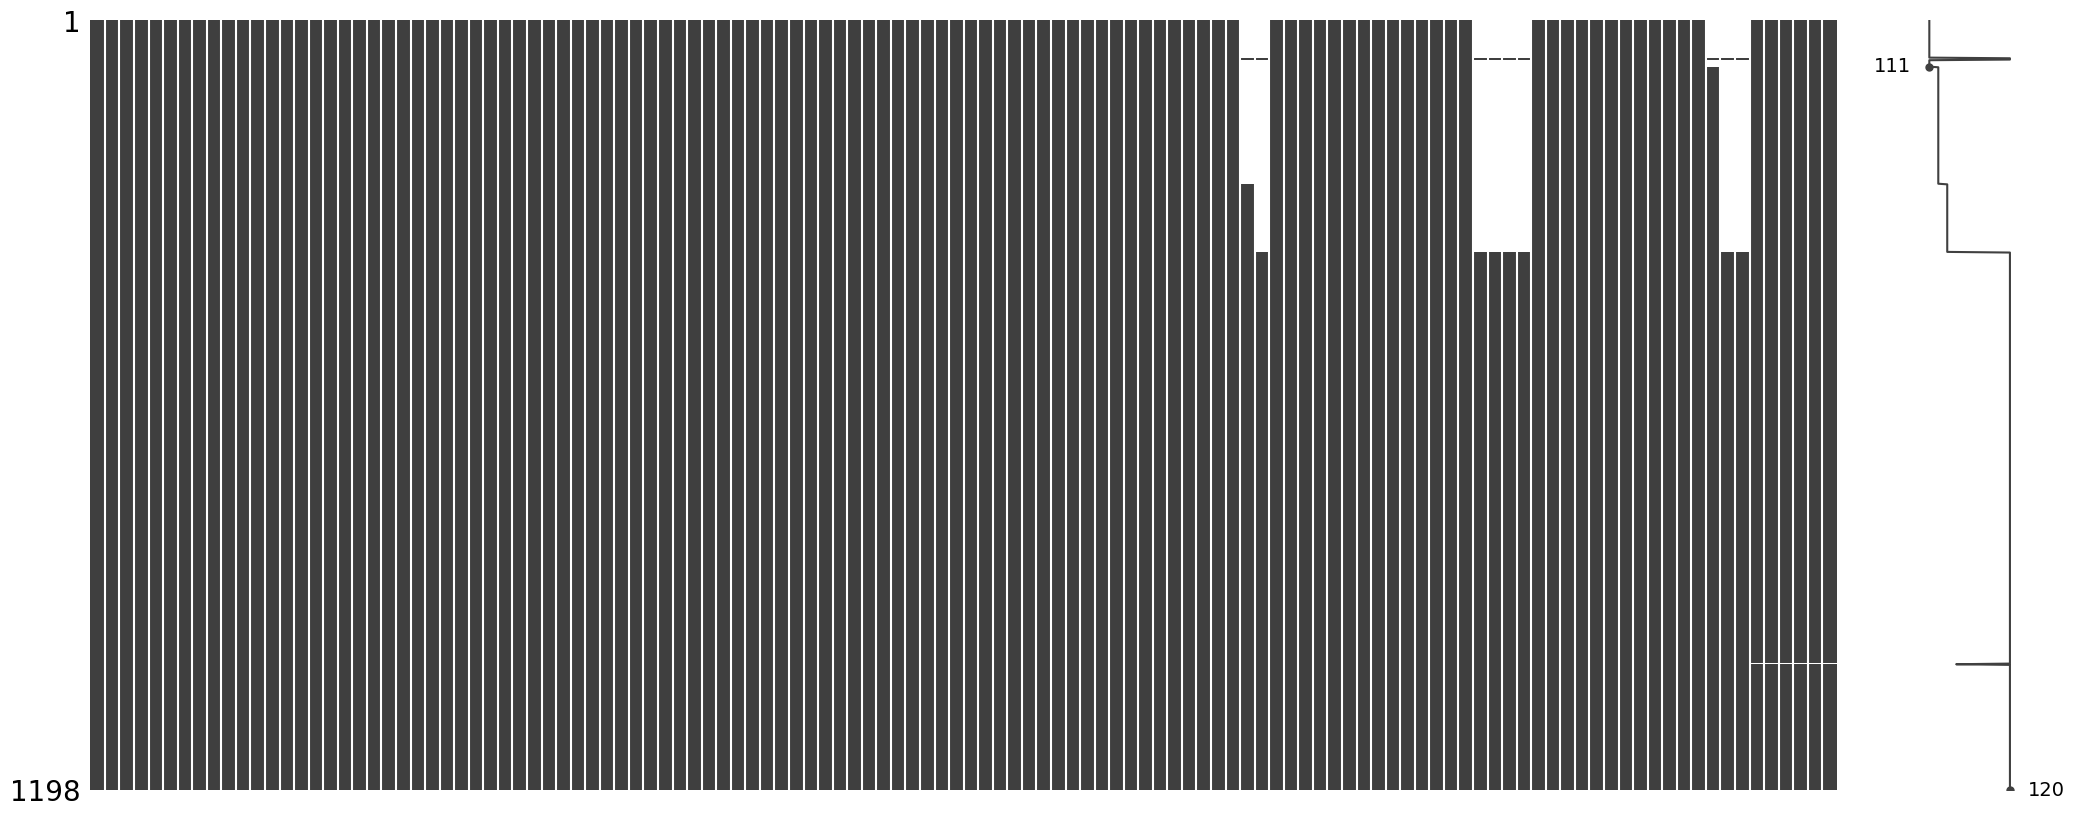

In [12]:
# --- Eliminar columnas sin información ---

# Eliminar columnas con más del 30% de valores NaN
df_full = df_full.loc[:, df_full.isna().mean() < 0.3]

# Tamaño del dataset después de eliminar columnas sin información
print("Columnas eliminadas por tener más del 30% de valores NaN:", df.shape[1] - df_full.shape[1])
print(f"Forma del dataset después de eliminar columnas sin información: {df_full.shape}")
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df_full)
plt.show()

In [13]:
from aux_functions import track_data_artifact

df_full.to_csv(PROCESSED_DIR / 'dataset_v2.csv')

track_data_artifact(
	PROCESSED_DIR / 'dataset_v2.csv',
	'Dataset con fechas normalizadas y gaps expuestos',
	[PROCESSED_DIR / 'dataset_v2.csv'],
	parameters={'description': 'Dataset con fechas normalizadas, gaps expuestos y mantenimientos de agosto imputados a 0'},
	base_dir=BASE_DIR,
	checksums_file_path=DATA_DIR / 'checksums.json',
	lineage_file_path=PROCESSED_DIR / 'data_lineage.json',
)

2025-11-16 17:37:09,772 - --- Iniciando tracking de artefacto para: dataset_v2.csv ---
2025-11-16 17:37:09,774 - Checksum (SHA256): e582342042b48be1d1dd485bb0c9ee69142ecc7098d1be2140e5ee77baf5f97e
2025-11-16 17:37:09,775 - Checksum guardado en checksums.json
2025-11-16 17:37:09,775 - Data lineage actualizado en data_lineage.json
2025-11-16 17:37:09,776 - --- Tracking de artefacto completado ---


---

## 3. Split de Datos

Eliminamos dos días con outliers en la variable objetivo (seguramente podriamos tomar el valor anterior o algo similar, pero por ahora los eliminamos)

In [14]:
df_full["Frio (Kw)"].sort_values(ascending=False).head(10)

filas_a_eliminar = ["2021-11-28", "2021-04-30"]

df_full = df_full.drop(index=pd.to_datetime(filas_a_eliminar))


In [15]:
# Dividir en train, val y test para busqueda de hiperparámetros del pipeline de preprocesamiento

# Train 70%
train_size = int(len(df_full) * 0.7)
train_df = df_full.iloc[:train_size]

# Validation 10%
val_size = int(len(df_full) * 0.1)
val_df = df_full.iloc[train_size:train_size + val_size]

# Test 20%
test_df = df_full.iloc[train_size + val_size:]

print("Train:")
print(f"- shape: {train_df.shape}")
print(f"- Rango: {train_df.index.min()} to {train_df.index.max()}")

print("\nValidation:")
print(f"- shape: {val_df.shape}")
print(f"- Rango: {val_df.index.min()} to {val_df.index.max()}")

print("\nTest:")
print(f"- shape: {test_df.shape}")
print(f"- Rango: {test_df.index.min()} to {test_df.index.max()}")



Train:
- shape: (837, 120)
- Rango: 2020-07-01 00:00:00 to 2022-10-25 00:00:00

Validation:
- shape: (119, 120)
- Rango: 2022-10-26 00:00:00 to 2023-02-23 00:00:00

Test:
- shape: (240, 120)
- Rango: 2023-02-24 00:00:00 to 2023-10-25 00:00:00


Guardamos los split en csv

In [16]:
train_df.to_csv(PROCESSED_DIR / "dataset_train_v2.csv")
val_df.to_csv(PROCESSED_DIR / "dataset_val_v2.csv")
test_df.to_csv(PROCESSED_DIR / "dataset_test_v2.csv")

Agregamos la columna objetivo para train

In [17]:
# Crear la columna objetivo desplazada en train_df
train_df['target_frio'] = train_df['Frio (Kw)'].shift(-1)

# Eliminar la última fila que queda con NaN en el target
train_df = train_df.iloc[:-1]

# (Opcional) chequeo
print(train_df[['Frio (Kw)', 'target_frio']].tail())


            Frio (Kw)  target_frio
2022-10-20    17036.0      17114.0
2022-10-21    17114.0      16743.0
2022-10-22    16743.0      17942.0
2022-10-23    17942.0      20189.0
2022-10-24    20189.0      22990.0


### Pipeline de preprocesamiento

Vamos a crear transformadores para tratar outliers e imputar valores faltantes. Luego, vamos a juntarlos en un pipeline de preprocesamiento.

**Transformador de outliers** (detectando por LOF)

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class LOFOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="winsorize", std_factor=3):
        """
        method: 'winsorize' o 'clip'
        std_factor: número de desvíos estándar para clipping
        """
        self.method = method
        self.std_factor = std_factor
        self.columns_ = None

    def fit(self, X, y=None):
        # Aseguramos DataFrame
        X = pd.DataFrame(X)
        self.columns_ = X.columns

        # Guardamos también los nombres como hace sklearn
        self.feature_names_in_ = self.columns_

        # Entrenamos LOF solo para detectar outliers (por ahora solo guardamos la máscara)
        lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
        self.outlier_mask_ = lof.fit_predict(X) == -1

        # Estadísticos por columna
        self.means_ = X.mean()
        self.stds_ = X.std()
        self.p1_ = X.quantile(0.01)
        self.p99_ = X.quantile(0.99)

        return self

    def transform(self, X):
        # Volvemos a DataFrame con mismas columnas
        X = pd.DataFrame(X, columns=self.columns_)

        if self.method == "winsorize":
            # Winsorización p1–p99 por columna
            X = X.clip(lower=self.p1_, upper=self.p99_, axis=1)

        elif self.method == "clip":
            # Clipping por medias ± k*std por columna
            lower = self.means_ - self.std_factor * self.stds_
            upper = self.means_ + self.std_factor * self.stds_
            X = X.clip(lower=lower, upper=upper, axis=1)

        # Devolvemos DataFrame con mismo índice y columnas
        return X


**Transformador de imputación** por KNN, linearRegression y MICE

In [19]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.base import BaseEstimator, TransformerMixin

class ImputationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, method="knn"):
        """
        method: 'knn', 'linear', 'mice'
        """
        self.method = method

    def fit(self, X, y=None):
        # Guardar columnas e índice
        self.columns_ = X.columns
        self.index_ = X.index
        
        # Elegir imputador
        if self.method == "knn":
            self.imputer_ = KNNImputer(n_neighbors=5)

        elif self.method == "linear":
            self.imputer_ = IterativeImputer(
                estimator=LinearRegression(),
                max_iter=20,
                random_state=42
            )

        elif self.method == "mice":
            self.imputer_ = IterativeImputer(
                estimator=BayesianRidge(),
                max_iter=20,
                random_state=42
            )

        # Ajustar imputador (recibe numpy, pero X es DataFrame y funciona igual)
        self.imputer_.fit(X)

        return self

    def transform(self, X):
        # Asegurar que X sea DataFrame con columnas correctas (evita problemas dentro del Pipeline)
        X = pd.DataFrame(X, columns=self.columns_)

        # Imputación
        X_imp = self.imputer_.transform(X)

        # Devolver DataFrame con columnas e índice originales
        return pd.DataFrame(X_imp, columns=self.columns_, index=X.index)


**Transformador para asimetría**

In [20]:
from sklearn.preprocessing import PowerTransformer

class SkewTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method="none"):
        self.method = method

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.feature_names_in_ = X.columns
        self.num_cols_ = X.select_dtypes(include=[np.number]).columns

        if self.method == "yeojohnson":
            self.pt_ = PowerTransformer(method="yeo-johnson", standardize=False)
            self.pt_.fit(X[self.num_cols_])

        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.feature_names_in_)

        if self.method == "none":
            return X

        if self.method == "yeojohnson":
            X_num = X[self.num_cols_]
            X[self.num_cols_] = self.pt_.transform(X_num)

        return X


**Pipeline de preprocesamiento** 

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

def build_pipeline(impute_method, outlier_method, std_factor, skew_method):
    pipe = Pipeline([
        ("imputer", ImputationSelector(method=impute_method)),
        ("outliers", LOFOutlierHandler(method=outlier_method, std_factor=std_factor)),
        ("skew", SkewTransformer(method=skew_method)),
        ("model", RandomForestRegressor(
            n_estimators=500,
            max_depth=28,
            random_state=42
        ))
    ])
    return pipe


**Búsqueda de mejores hiperparámetros del pipeline con optuna**

In [22]:
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

def objective(trial):

    impute_method  = trial.suggest_categorical("imputer", ["knn", "linear", "mice"])
    outlier_method = trial.suggest_categorical("outliers", ["winsorize", "clip"])
    std_factor     = trial.suggest_float("std_factor", 2.0, 5.0)

    # Solo estos dos métodos
    skew_method    = trial.suggest_categorical("skew_method", ["none", "yeojohnson"])

    pipe = build_pipeline(impute_method, outlier_method, std_factor, skew_method)

    tscv = TimeSeriesSplit(n_splits=4)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_df)):

        X_train = train_df.iloc[train_idx].drop(columns=["target_frio"])
        y_train = train_df.iloc[train_idx]["target_frio"]

        X_val = train_df.iloc[val_idx].drop(columns=["target_frio"])
        y_val = train_df.iloc[val_idx]["target_frio"]

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_val)

        mae = mean_absolute_error(y_val, preds)
        scores.append(mae)

        trial.report(mae, step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(scores)


study = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=5)
)

study.optimize(objective, n_trials=20)

print(study.best_params)
print("Best MAE:", study.best_value)


[I 2025-11-16 17:37:10,259] A new study created in memory with name: no-name-d0efa99f-1664-4147-a2df-3fabbc6d4eb1
[I 2025-11-16 17:37:43,631] Trial 0 finished with value: 3752.393539244563 and parameters: {'imputer': 'linear', 'outliers': 'winsorize', 'std_factor': 4.227395216459139, 'skew_method': 'yeojohnson'}. Best is trial 0 with value: 3752.393539244563.
[I 2025-11-16 17:39:14,250] Trial 1 finished with value: 3742.8352911297534 and parameters: {'imputer': 'mice', 'outliers': 'clip', 'std_factor': 4.4677889741992205, 'skew_method': 'yeojohnson'}. Best is trial 1 with value: 3742.8352911297534.
[I 2025-11-16 17:39:50,331] Trial 2 finished with value: 3733.8956599864123 and parameters: {'imputer': 'linear', 'outliers': 'clip', 'std_factor': 4.771256028776747, 'skew_method': 'yeojohnson'}. Best is trial 2 with value: 3733.8956599864123.
[I 2025-11-16 17:40:19,635] Trial 3 finished with value: 3782.4526161923986 and parameters: {'imputer': 'knn', 'outliers': 'winsorize', 'std_factor':

{'imputer': 'linear', 'outliers': 'clip', 'std_factor': 4.378253933658169, 'skew_method': 'yeojohnson'}
Best MAE: 3729.639967920544


In [23]:
# 1. Mejores hiperparámetros
best_params_preproc = study.best_params
best_imputer = best_params_preproc["imputer"]
best_outliers = best_params_preproc["outliers"]
best_std_factor = best_params_preproc["std_factor"]
best_skew_method = best_params_preproc["skew_method"]

# 2. Pipeline SOLO de preprocesamiento (sin modelo)

best_pipe_preprocess = Pipeline([
    ("imputer", ImputationSelector(method=best_imputer)),
    ("outliers", LOFOutlierHandler(method=best_outliers, std_factor=best_std_factor)),
    ("skew", SkewTransformer(method=best_skew_method))
])


X_train = train_df.drop(columns=["target_frio"])
y_train = train_df["target_frio"]

# fit + transform en un paso
x_train_processed = best_pipe_preprocess.fit_transform(X_train)

print(best_params_preproc)

{'imputer': 'linear', 'outliers': 'clip', 'std_factor': 4.378253933658169, 'skew_method': 'yeojohnson'}


## Pipeline para crear las features temporales

In [24]:
class TimeSeriesFeatureEngineerIndex(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        target_col="Frio (Kw)",
        lags=(1, 2, 3),
        ma_windows=(3, 7)
    ):
        self.target_col = target_col
        self.lags = lags
        self.ma_windows = ma_windows

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Aseguramos que el índice sea datetime
        X.index = pd.to_datetime(X.index)

        # ------- LAGS de Frio (Kw) -------
        for lag in self.lags:
            col_name = f"{self.target_col}_lag_{lag}"
            X[col_name] = X[self.target_col].shift(lag)

        # ------- Promedios móviles de Frio (Kw) -------
        for window in self.ma_windows:
            col_name = f"{self.target_col}_ma_{window}"
            X[col_name] = (
                X[self.target_col]
                .rolling(window=window, min_periods=1)
                .mean()
            )

        # ------- Features de calendario desde el índice -------
        # 0 = lunes, 6 = domingo
        X["day_of_week"] = X.index.dayofweek
        X["month"] = X.index.month
        X["is_weekend"] = X["day_of_week"].isin([5, 6]).astype(int)

        return X


In [25]:
feature_pipe = Pipeline([
    ("time_features", TimeSeriesFeatureEngineerIndex(
        target_col="Frio (Kw)",
        lags=(1, 2, 3, 24),   
        ma_windows=(3, 7, 14) 
    ))
])


X_train_features = feature_pipe.fit_transform(x_train_processed)

X_train_features.head()

,Planta (Kw),Elaboracion (Kw),Bodega (Kw),Cocina (Kw),Envasado (Kw),Linea 2 (Kw),Linea 3 (Kw),Linea 4 (Kw),Servicios (Kw),Sala Maq (Kw),...,Frio (Kw)_lag_1,Frio (Kw)_lag_2,Frio (Kw)_lag_3,Frio (Kw)_lag_24,Frio (Kw)_ma_3,Frio (Kw)_ma_7,Frio (Kw)_ma_14,day_of_week,month,is_weekend
2020-07-01,2267.655424,8564.790625,5457.914545,663.120705,28.467796,499.960733,657.935993,0.000000,201302.671856,60.188447,...,NaN,NaN,NaN,NaN,12904.762227,12904.762227,12904.762227,2,7,0
2020-07-02,3703.873607,28090.809437,10869.960407,19197.436029,111.051618,1206.167002,7860.451834,6558.770430,357808.296689,69.832953,...,12904.762227,NaN,NaN,NaN,17174.555636,17174.555636,17174.555636,3,7,0
2020-07-03,4245.142712,34845.799108,12230.535454,30385.105123,106.324333,584.038654,7268.842666,6731.867976,411062.223531,73.067141,...,21444.349045,12904.762227,NaN,NaN,19868.156128,19868.156128,19868.156128,4,7,0
2020-07-04,4311.080019,30020.484622,9223.534596,61730.905865,116.669618,2182.896878,7808.262193,6760.976549,376646.580657,70.522066,...,25255.357110,21444.349045,12904.762227,NaN,22800.752641,20326.755038,20326.755038,5,7,1
2020-07-05,4472.884152,39570.509171,12565.891589,57736.141956,106.361620,2115.484595,4064.608860,6702.756362,444870.427530,74.567119,...,21702.551768,25255.357110,21444.349045,NaN,24546.613869,21597.790576,21597.790576,6,7,1


### Selección de características

In [26]:
from sklearn.model_selection import cross_val_score

# ============================================
# 1. Partimos desde tu X, y y ordered_features
# ============================================

X = X_train_features  # ya preprocesado
y = y_train

if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X, index=train_df.index)

feature_names = X.columns

# Random forest para calcular importancias
rf_importance = RandomForestRegressor(
    n_estimators=523,
    max_depth=28,
    random_state=42,
    n_jobs=-1
)

rf_importance.fit(X, y)

importances = rf_importance.feature_importances_

# Ranking de features (más importantes primero)
ordered_features = [
    name for _, name in sorted(
        zip(importances, feature_names),
        key=lambda x: x[0],
        reverse=True
    )
]

# Opcional: ver top 20
for name, imp in list(sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True))[:20]:
    print(f"{name}: {imp:.4f}")

Frio (Kw): 0.5000
Frio (Kw)_ma_3: 0.0650
Frio (Kw)_ma_14: 0.0603
Sala Maq (Kw): 0.0318
Frio (Kw)_ma_7: 0.0230
Servicios (Kw): 0.0206
KW Obrador Contratistas: 0.0136
Frio (Kw)_lag_2: 0.0116
Tot  A130/330/430: 0.0106
KW Servicio L2: 0.0098
Frio (Kw)_lag_3: 0.0068
Frio (Kw)_lag_24: 0.0061
KW Laboratorio: 0.0057
Totalizador_Aire_Cocina: 0.0054
Tot Vap Lav L3 / Hora: 0.0051
KW Bba Glicol Sala MAq: 0.0050
KW Gral Planta_Totalizadores Energia: 0.0046
Restos Planta (Kw): 0.0046
Kw Admininistracion: 0.0046
KW Bba Glicol Bod: 0.0045


In [27]:
from sklearn.model_selection import TimeSeriesSplit

# ============================================
# 2. Study de Optuna para elegir el número óptimo de variables (MAE + poda, TimeSeriesSplit)
# ============================================

def objective(trial):
    # Número de features a usar
    n_features = trial.suggest_int(
        "n_features",
        10,
        len(ordered_features)
    )
    
    # Selección de features top-k
    selected_features = ordered_features[:n_features]
    X_sel = X[selected_features]

    # Modelo base (fijo)
    model = RandomForestRegressor(
        n_estimators=523,
        max_depth=28,
        random_state=42,
        n_jobs=-1
    )

    # TimeSeriesSplit en lugar de KFold(shuffle=True)
    tscv = TimeSeriesSplit(n_splits=5)
    maes = []

    for fold_idx, (train_idx, valid_idx) in enumerate(tscv.split(X_sel)):
        X_train_fold = X_sel.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]

        X_valid_fold = X_sel.iloc[valid_idx]
        y_valid_fold = y.iloc[valid_idx]

        # Entrenamos el modelo
        model.fit(X_train_fold, y_train_fold)

        # Predicción
        y_pred = model.predict(X_valid_fold)

        # MAE del fold
        mae = mean_absolute_error(y_valid_fold, y_pred)
        maes.append(mae)

        # Reporte intermedio para pruning
        trial.report(mae, step=fold_idx)

        # Si Optuna decide podar → corta este trial
        if trial.should_prune():
            raise optuna.TrialPruned()

    # MAE promedio final
    return np.mean(maes)

# Crear estudio con pruning
study = optuna.create_study(
    direction="minimize",
    pruner=MedianPruner(n_warmup_steps=10)
)

study.optimize(objective, n_trials=50)

print("Mejores parámetros:", study.best_params)
print("Mejor MAE:", study.best_value)

# ============================================
# 3. Recuperar el mejor set de features
# ============================================
best_n_features = study.best_params["n_features"]
best_features = ordered_features[:best_n_features]

print(f"Mejor número de features: {best_n_features}")
print("Features seleccionadas:")
print(best_features)


[I 2025-11-16 17:55:16,049] A new study created in memory with name: no-name-c0f28360-a880-4b9f-93a0-1819af22be28
[I 2025-11-16 17:55:22,749] Trial 0 finished with value: 4712.479821725794 and parameters: {'n_features': 117}. Best is trial 0 with value: 4712.479821725794.
[I 2025-11-16 17:55:29,565] Trial 1 finished with value: 4712.479821725794 and parameters: {'n_features': 117}. Best is trial 0 with value: 4712.479821725794.
[I 2025-11-16 17:55:34,176] Trial 2 finished with value: 4679.714554933491 and parameters: {'n_features': 73}. Best is trial 2 with value: 4679.714554933491.
[I 2025-11-16 17:55:39,873] Trial 3 finished with value: 4651.09023481024 and parameters: {'n_features': 91}. Best is trial 3 with value: 4651.09023481024.
[I 2025-11-16 17:55:41,585] Trial 4 finished with value: 4695.413150473885 and parameters: {'n_features': 14}. Best is trial 3 with value: 4651.09023481024.
[I 2025-11-16 17:55:48,344] Trial 5 finished with value: 4741.825929543173 and parameters: {'n_fe

Mejores parámetros: {'n_features': 10}
Mejor MAE: 4596.536297233723
Mejor número de features: 10
Features seleccionadas:
['Frio (Kw)', 'Frio (Kw)_ma_3', 'Frio (Kw)_ma_14', 'Sala Maq (Kw)', 'Frio (Kw)_ma_7', 'Servicios (Kw)', 'KW Obrador Contratistas', 'Frio (Kw)_lag_2', 'Tot  A130/330/430', 'KW Servicio L2']


Ahora, resumimos todos el preprocesamiento en un solo pipeline. Esto incluye:
- Tratamiento de outliers
- Imputación de valores faltantes
- Creación de features temporales (lags, promedios moviles, booleano es fin de semana, etc)
- selección de características

In [28]:
from sklearn.preprocessing import StandardScaler

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        # opcional: podrías validar que todas existan
        self.feature_names_ = self.feature_names
        return self

    def transform(self, X):
        # aseguramos DataFrame
        X = pd.DataFrame(X)
        return X[self.feature_names_]



best_imputer = best_params_preproc["imputer"]       # ej. 'knn', 'linear', 'mice'
best_outliers = best_params_preproc["outliers"]     # ej. 'winsorize' o 'clip'
best_std_factor = best_params_preproc["std_factor"]
best_skew_method = best_params_preproc["skew_method"]   # ej. 'none' o 'yeojohnson'

# Y estos del estudio de selección de features

full_preprocess_pipe = Pipeline([
    ("imputer", ImputationSelector(method=best_imputer)),
    ("outliers", LOFOutlierHandler(method=best_outliers, std_factor=best_std_factor)),
    ("time_features", TimeSeriesFeatureEngineerIndex(
        target_col="Frio (Kw)",
        lags=(1, 2, 3, 24),
        ma_windows=(3, 7, 14),
    )),
    ("feature_selector", FeatureSelector(best_features)),
    ("skew", SkewTransformer(method=best_skew_method)), 
    ("scaler", StandardScaler())  
])


### Procesado y guardado del dataset

Guardar el conjunto de datos final y limpio en data/processed/dataset_final.csv. Calcular y añadir su check-
sum al archivo checksums.json.

In [ ]:
from aux_functions import track_data_artifact

def drop_na(X):
    mask = ~X.isna().any(axis=1)
    X = X.loc[mask]
    return X

df_cleaned = full_preprocess_pipe.fit_transform(df_full)

df_cleaned = pd.DataFrame(df_cleaned, index=df_full.index, columns=best_features)

df_cleaned = drop_na(df_cleaned)

output_path = PROCESSED_DIR / "dataset_v3.csv"
df_cleaned.to_csv(output_path, index=True) 

track_data_artifact(
    output_path,
    "Dataset preprocesado final con features seleccionadas",
    [output_path],
    parameters={
        "description": (
            "Dataset preprocesado final. Imputación, manejo de outliers, "
            "features de tiempo, selección de features, transformación de skew y escalado"
        )
    },
    base_dir=BASE_DIR,
    checksums_file_path=DATA_DIR / "checksums.json",
    lineage_file_path=PROCESSED_DIR / "data_lineage.json",
)


2025-11-16 18:01:00,000 - --- Iniciando tracking de artefacto para: dataset_v3.csv ---
2025-11-16 18:01:00,002 - Checksum (SHA256): 1d481abb9b115235b1780f52a8d3dbe308cb6a284422e9fef585ca65db125c9e
2025-11-16 18:01:00,003 - Checksum guardado en checksums.json
2025-11-16 18:01:00,004 - Data lineage actualizado en data_lineage.json
2025-11-16 18:01:00,005 - --- Tracking de artefacto completado ---
